## Summary

---

## Imports

In [1]:
import functools
from pathlib import Path

import elaspic2 as el2
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from sklearn import metrics, model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

In [2]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

## Parameters

In [3]:
NOTEBOOK_DIR = Path("38_cagi6_sherloc_train_model").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/39_cagi6_sherloc_submission')

## Load data

In [4]:
submission_template_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "submission_template.tsv"
)

submission_template_df = pd.read_csv(submission_template_file, sep="\t")

display(submission_template_df.head(2))
len(submission_template_df)

,hgvs,score,class,comment
0,NM_152486.2:c.39C>T,*,*,*
1,NM_152486.2:c.62C>T,*,*,*


122124

### `training_df`

In [5]:
training_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc",
    "CAGI6-Sherloc-clinical-classification",
    "final_train_070821.txt",
)

In [6]:
training_all_df = pd.read_csv(training_file, sep="\t")

display(training_all_df.head(2))
len(training_all_df)

/home/strokach/envs/default-v46/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chr,pos,ref,alt,hgvs,interpretation,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
0,1,861332,G,A,NM_152486.2:c.11G>A,Uncertain significance,True,False,False
1,1,865568,G,A,NM_152486.2:c.106G>A,Uncertain significance,True,False,False


418354

In [7]:
assert not set(submission_template_df["hgvs"]) & set(training_all_df["hgvs"])

In [8]:
training_df = training_all_df[training_all_df["Subcategory Missense"]]

display(training_df.head(2))
len(training_df)

,chr,pos,ref,alt,hgvs,interpretation,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
0,1,861332,G,A,NM_152486.2:c.11G>A,Uncertain significance,True,False,False
1,1,865568,G,A,NM_152486.2:c.106G>A,Uncertain significance,True,False,False


217153

### `testing_df`

In [9]:
testing_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "CAGI6-Sherloc-clinical-classification", "final_test_070821.txt"
)

In [10]:
testing_all_df = pd.read_csv(testing_file, sep="\t")

display(testing_all_df.head(2))
len(testing_all_df)

/home/strokach/envs/default-v46/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,chr,pos,ref,alt,hgvs,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
0,1,861360,C,T,NM_152486.2:c.39C>T,False,False,False
1,1,861383,C,T,NM_152486.2:c.62C>T,True,False,False


122124

In [11]:
assert not set(submission_template_df["hgvs"]) ^ set(testing_all_df["hgvs"])

In [12]:
testing_df = testing_all_df[testing_all_df["Subcategory Missense"]]

display(testing_df.head(2))
len(testing_df)

,chr,pos,ref,alt,hgvs,Subcategory Missense,Subcategory Small intronic deletion or insertion,Subcategory Small exonic in-frame deletion or insertion
1,1,861383,C,T,NM_152486.2:c.62C>T,True,False,False
7,1,865640,G,A,NM_152486.2:c.178G>A,True,False,False


47103

### `validation_df`

In [13]:
validation_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_sherloc", "validation_variants.tsv")

In [14]:
validation_all_df = pd.read_csv(validation_file, sep="\t").rename(columns={"HGVS.c": "hgvs_g"})

display(validation_all_df.tail(2))
len(validation_all_df)

,hgvs_g
17812,NC_000023.10:g.32519861C>T
17813,NC_000015.9:g.85406864_85406865insT


17814

In [15]:
def map_g_to_c(str_g, mapper):
    from hgvs.exceptions import HGVSInvalidIntervalError, HGVSUsageError

    var_g = hp.parse_hgvs_variant(str_g)
    for tx_ac in mapper.relevant_transcripts(var_g):
        try:
            var_c = mapper.g_to_c(var_g, tx_ac)
        except (HGVSUsageError, HGVSInvalidIntervalError):
            continue
        yield var_c

In [16]:
validation_mapping_file = NOTEBOOK_DIR.parent.joinpath(
    "30_cagi6_sherloc", "validation-mapping-grch37.parquet"
)

if validation_mapping_file.is_file():
    validation_mapping_df = pq.read_table(validation_mapping_file).to_pandas()
else:
    import hgvs.assemblymapper
    import hgvs.dataproviders.uta
    import hgvs.parser

    hp = hgvs.parser.Parser()
    hdp = hgvs.dataproviders.uta.connect()
    mapper = hgvs.assemblymapper.AssemblyMapper(hdp, assembly_name="GRCh37", normalize=False)

    results = []
    for tup in tqdm(validation_all_df.itertuples(), total=len(validation_all_df)):
        for var_c in map_g_to_c(tup.hgvs_g, mapper):
            results.append((tup.str_g, str(var_c)))
    validation_mapping_df = pd.DataFrame(results, columns=["hgvs_g", "hgvs"])
    pq.write_table(
        pa.Table.from_pandas(validation_mapping_df, preserve_index=False),
        validation_mapping_file,
    )

In [17]:
display(validation_mapping_df.head(2))
print(len(validation_mapping_df))

,hgvs_g,hgvs
0,NC_000002.11:g.152537358A>G,NM_001164508.1:c.2944-16T>C
1,NC_000002.11:g.152537358A>G,NM_004543.4:c.2944-16T>C


67819


In [18]:
validation_df = (
    validation_all_df
    #
    .merge(validation_mapping_df, on=["hgvs_g"], how="left")
)

In [19]:
display(validation_df.tail(2))
print(len(validation_df))
print(len(validation_df["hgvs_g"].unique()))

,hgvs_g,hgvs
67830,NC_000023.10:g.32519861C>T,NM_004010.3:c.2011+11G>A
67831,NC_000015.9:g.85406864_85406865insT,NM_020778.4:c.5098_5099insT


67832
17814


## Load results

In [20]:
DATASET_NAME = "cagi6-sherloc"

DATASET_NAME

'cagi6-sherloc'

In [21]:
input_file = NOTEBOOK_DIR.parent.joinpath(
    "37_cagi6_sherloc_combine_results", "combined-results.parquet"
)

input_file

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/37_cagi6_sherloc_combine_results/combined-results.parquet')

In [23]:
result_df = pq.read_table(input_file).to_pandas()

display(result_df.head(2))
print(len(result_df))

,protein_id,mutation,mutation_id,effect,proteinsolver_core_score_wt,proteinsolver_core_features_residue_wt,proteinsolver_core_features_protein_wt,protbert_core_score_wt,protbert_core_features_residue_wt,protbert_core_features_protein_wt,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,rosetta_dslf_fa13_wt,rosetta_hbond_sc_wt,rosetta_hbond_bb_sc_wt,rosetta_hbond_lr_bb_wt,rosetta_hbond_sr_bb_wt,rosetta_fa_intra_elec_wt,rosetta_fa_elec_wt,rosetta_lk_ball_bridge_uncpl_wt,rosetta_lk_ball_bridge_wt,rosetta_lk_ball_iso_wt,rosetta_lk_ball_wt,rosetta_fa_intra_sol_xover4_wt,rosetta_fa_intra_rep_xover4_wt,rosetta_fa_intra_atr_xover4_wt,rosetta_fa_sol_wt,rosetta_fa_rep_wt,rosetta_fa_atr_wt,rosetta_dg_wt,rosetta_cart_bonded_change,rosetta_rama_prepro_change,rosetta_ref_change,rosetta_hxl_tors_change,rosetta_p_aa_pp_change,rosetta_fa_dun_semi_change,rosetta_fa_dun_rot_change,rosetta_fa_dun_dev_change,rosetta_omega_change,rosetta_dslf_fa13_change,rosetta_hbond_sc_change,rosetta_hbond_bb_sc_change,rosetta_hbond_lr_bb_change,rosetta_hbond_sr_bb_change,rosetta_fa_intra_elec_change,rosetta_fa_elec_change,rosetta_lk_ball_bridge_uncpl_change,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,alphafold_core_scores_residue_plddt_wt,alphafold_core_scores_protein_plddt_wt,alphafold_core_scores_protein_max_predicted_aligned_error_wt,alphafold_core_scores_proten_ptm_wt,alphafold_core_features_residue_experimentally_resolved_wt,alphafold_core_features_residue_predicted_lddt_wt,alphafold_core_features_residue_msa_first_row_wt,alphafold_core_features_residue_single_wt,alphafold_core_features_residue_structure_module_wt,alphafold_core_features_protein_experimentally_resolved_wt,alphafold_core_features_protein_predicted_lddt_wt,alphafold_core_features_protein_msa_first_row_wt,alphafold_core_features_protein_single_wt,alphafold_core_features_protein_structure_module_wt,el2_score,proteinsolver_core_score_change,proteinsolver_core_features_residue_change,proteinsolver_core_features_protein_change,protbert_core_score_change,protbert_core_features_residue_change,protbert_core_features_protein_change,alphafold_core_scores_residue_plddt_change,alphafold_core_scores_protein_plddt_change,alphafold_core_scores_protein_max_predicted_aligned_error_change,alphafold_core_scores_proten_ptm_change,alphafold_core_features_residue_experimentally_resolved_change,alphafold_core_features_residue_predicted_lddt_change,alphafold_core_features_residue_msa_first_row_change,alphafold_core_features_residue_single_change,alphafold_core_features_residue_structure_module_change,alphafold_core_features_protein_experimentally_resolved_change,alphafold_core_features_protein_predicted_lddt_change,alphafold_core_features_protein_msa_first_row_change,alphafold_core_features_protein_single_change,alphafold_core_features_protein_structure_module_change,aa_wt_onehot,aa_mut_onehot
0,P26678,R9C,NM_002667.3:c.25C>T,Pathogenic,0.091593,"[0.48249053955078125, 0.24484702944755554, -0....","[-2.27313494682312, 0.6932704448699951, -0.195...",0.068529,"[0.15305250883102417, -0.11011786758899689, 0....","[0.05504663661122322, -0.04564127326011658, 0....",34.796667,18.080333,13.08,5.875333,-4.878333,33.826333,30.420,37.201667,16.900333,0.0,0.0,-0.495,0.0,-46.239,-5.748,-96.294333,-1.515667,-0.220333,-145.437333,123.757667,12.501667,9.146667,-22.659333,279.312667,18.309,-311.028667,-1.308,-0.577667,0.614667,4.553,0.021333,0.376000,0.173000,-1.592000,-0.074667,-0.012667,0.0,0.000,0.495000,0.0,-0.011,-0.510333,0.204667,0.508667,0.040,1.679,-0.050333,-0.104333,-0.147,0.325000,-4.542667,0.084667,2.215667,3.669,60.585841,76.416854,31.75,0.427586,"[1.1943495, 1.214369

221816


## Exploratory data analysis

In [28]:
proteinsolver_columnms = [c for c in result_df if c.startswith("proteinsolver_")]
protbert_columns = [c for c in result_df if c.startswith("protbert_")]
rosetta_columns = [c for c in result_df if c.startswith("rosetta_")]
alphafold_columns = [c for c in result_df if c.startswith("alphafold_")]

In [29]:
result_df["effect"].value_counts()

Uncertain significance    147067
Likely benign              11398
Benign                      9730
Pathogenic                  5834
Likely pathogenic           2506
Name: effect, dtype: int64

In [30]:
effect_map = {
    "Uncertain significance": 0,
    "Likely benign": -1,
    "Benign": -2,
    "Likely pathogenic": 1,
    "Pathogenic": 2,
}

result_df["effect_score"] = result_df["effect"].map(effect_map)

In [31]:
score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    "rosetta_dg_change",
    #     "alphafold_core_scores_residue_plddt_wt",
    #     "alphafold_core_scores_protein_plddt_wt",
    #     "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
    #     "alphafold_core_scores_proten_ptm_wt",
]

df = result_df.dropna(subset=score_columns + ["effect_score"])
# df = df[df["effect_score"].isin([-1, 1])].reset_index(drop=True)

for col in score_columns:
    corr = stats.spearmanr(df["effect_score"], df[col])
    auc = metrics.roc_auc_score(df["effect_score"] > 0, df[col])
    print(col, corr[0], auc)

el2_score 0.20904092413334513 0.8102172600274852
proteinsolver_core_score_change 0.12333787494792897 0.6756977519399014
protbert_core_score_change 0.17309841808091103 0.7703863336833652
rosetta_dg_change 0.10878939601804864 0.6463044888240757


## Train ML model

### Prepare dataset

In [36]:
rosetta_columns = [c for c in result_df if "rosetta" in c]

scalar_features = [
#     "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
]
vector_features = [
    "aa_wt_onehot",
    "aa_mut_onehot",
    "protbert_core_features_residue_wt",
    "protbert_core_features_residue_change",
    "proteinsolver_core_features_residue_wt",
    "proteinsolver_core_features_residue_change",
    #     "protbert_core_features_protein_wt",
    #     "protbert_core_features_protein_change",
    #     "proteinsolver_core_features_protein_wt",
    #     "proteinsolver_core_features_protein_change",
    #
    # AlphaFold
    #     "alphafold_core_features_residue_experimentally_resolved_wt",  # 0.19 [37]
    #     "alphafold_core_features_residue_experimentally_resolved_change",  # 0.11 [37]
    #     "alphafold_core_features_residue_predicted_lddt_wt",  # 0.17 [50]
    #     "alphafold_core_features_residue_predicted_lddt_change",  # 0.04 [50]
    #     "alphafold_core_features_residue_msa_first_row_wt",  # 0.17 [256]
    #     "alphafold_core_features_residue_msa_first_row_change",  # 0.21 [256]
    #     "alphafold_core_features_residue_single_wt",  # 0.20 [384]
    #     "alphafold_core_features_residue_single_change",  # 0.15 [384]
    #     "alphafold_core_features_residue_structure_module_wt",  # 0.18 [384]
    #     "alphafold_core_features_residue_structure_module_change",  # 0.05 [384]
]

#             "rosetta_dg_change",
#             "alphafold_core_features_residue_experimentally_resolved_wt",

df = (
    result_df.dropna(
        subset=scalar_features
        + vector_features
        + [
            "effect_score",
        ]
    )
    .sample(frac=1, random_state=0)
    .reset_index(drop=True)
)
# df = df[df["effect_score"] != 0].reset_index(drop=True)


X_ref = np.c_[
    df[scalar_features].values,
    np.hstack([np.vstack(df[col].values) for col in vector_features]),
]
X = X_ref
# X = X[:, important_features]


y = (df["effect_score"] > 0).values.astype(int)
y[df["effect_score"] == 0] = (df[df["effect_score"] == 0]["el2_score"] > 2).values.astype(int)
# y = df["effect_score"].values


weights = np.ones(len(df), dtype=np.float64)
weights[df["effect_score"] == 1] = 0.5
weights[df["effect_score"] == -1] = 0.5
weights[df["effect_score"] == 0] = 0.01

In [43]:
df["effect_score"].value_counts()

 0.0    142635
-1.0     11090
-2.0      9481
 2.0      5714
 1.0      2437
Name: effect_score, dtype: int64

In [44]:
from collections import Counter

Counter(y)

Counter({0: 137225, 1: 34132})

### Hyperparameter optimization

In [46]:
def training_loop(X, y, weights, param, n_splits=6, progressbar=False):
    models = []
    preds = np.ones(len(y), dtype=np.float64) * np.nan
    gkf = GroupKFold(n_splits=n_splits)
    for train_index, test_index in tqdm(
        gkf.split(X, y, groups=df["protein_id"]),
        total=n_splits,
        disable=not progressbar,
    ):
        X_training, X_testing = X[train_index], X[test_index]
        y_training, y_testing = y[train_index], y[test_index]
        weights_training, weights_testing = weights[train_index], weights[test_index]

        dtrain = lgb.Dataset(X_training, label=y_training, weight=weights_training)
        model = lgb.train(param, dtrain)
        preds[test_index] = model.predict(X_testing)
        models.append(model)
    return models, preds

In [47]:
def objective(trial, X, y, weights):
    param = {
        "objective": "binary",
        "metric": "auc",  # 'binary_logloss',
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 64),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 60),
    }
    models, preds = training_loop(X, y, weights, param)
    pred_labels = np.rint(preds)
    accuracy = metrics.accuracy_score(y, pred_labels)
    auc = metrics.roc_auc_score(y, preds)
    return auc

In [48]:
# study = optuna.create_study(direction="maximize")
# study.optimize(lambda trial: objective(trial, X, y, weights), n_trials=100)

# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)

In [49]:
# print("Number of finished trials:", len(study.trials))
# print("Best trial:", study.best_trial.params)

```json
Number of finished trials: 100
Best trial: {'lambda_l1': 5.233219055743764, 'lambda_l2': 0.00037944276593632404, 'num_leaves': 64, 'feature_fraction': 0.5395906681722488, 'bagging_fraction': 0.9467711664385872, 'bagging_freq': 5, 'min_child_samples': 15}
```

### Checkpoint model

In [ ]:
param = {
    "objective": "binary",
    "metric": "auc",  # 'binary_logloss',
    "lambda_l1": 5.233219055743764,
    "lambda_l2": 0.00037944276593632404,
    "num_leaves": 64,
    "feature_fraction": 0.5395906681722488,
    "bagging_fraction": 0.9467711664385872,
    "bagging_freq": 5,
    "min_child_samples": 15,
}

models, preds = training_loop(X, y, weights, param, progressbar=True)

mask = df["effect_score"] != 0
corr = stats.spearmanr(y[mask], preds[mask])
auc = metrics.roc_auc_score(y[mask], preds[mask])
print(corr[0], auc)

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 27882, number of negative: 114915
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.555240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588110
[LightGBM] [Info] Number of data points in the train set: 142797, number of used features: 2346
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307096 -> initscore=-0.813733
[LightGBM] [Info] Start training from score -0.813733


### Feature elimination

In [106]:
def get_feature_index(num_features, features_to_exclude):
    idx = 0
    seen = set(features_to_exclude)
    indices = list(reversed(range(num_features)))
    while indices:
        idx = indices.pop()
        while idx in seen:
            idx += 1
        seen.add(idx)
        yield idx


list(get_feature_index(10, {1, 2, 3, 9, 10}))

[0, 4, 5, 6, 7, 8, 11, 12, 13, 14]

In [126]:
features_to_exclude = {}

fe_round = -1
fe_round_stats = []
while len(features_to_exclude) < X_ref.shape[1]:
    fe_round += 1

    # Apply feature elimination mask
    feature_mask = np.ones(X_ref.shape[1], dtype=bool)
    feature_mask[np.array(list(features_to_exclude), dtype=int)] = False
    X = X_ref[:, feature_mask]

    # Re-train models
    models, preds = training_loop(X, y, weights, param, progressbar=True)

    # Calculate model statistics
    mask = df["effect_score"] != 0
    corr = stats.spearmanr(y[mask], preds[mask])
    auc = metrics.roc_auc_score(y[mask], preds[mask])

    # Save stats
    print(
        f"Performance at round {fe_round}:",
        corr[0],
        auc,
        len(features_to_exclude),
        X_ref.shape[1] - X.shape[1],
    )
    fe_round_stats.append((fe_round, corr[0], auc, len(features_to_exclude)))

    # Find new features to eliminate
    feature_importance_split = np.vstack(
        [model.feature_importance("split") for model in models]
    ).sum(axis=0)
    feature_importance_gain = np.vstack([model.feature_importance("gain") for model in models]).sum(
        axis=0
    )

    feature_df = pd.DataFrame(
        {
            "feature_idx": list(
                get_feature_index(len(feature_importance_split), features_to_exclude)
            ),
            "feature_importance_split": feature_importance_split,
            "feature_importance_gain": feature_importance_gain,
        }
    )

    min_split = feature_df["feature_importance_split"].min()
    feature_df = feature_df[feature_df["feature_importance_split"] == min_split]
    min_gain = feature_df["feature_importance_gain"].min()
    feature_df = feature_df[feature_df["feature_importance_gain"] == min_gain]
    new_features_to_exclude = feature_df["feature_idx"].values.tolist()

    for feature_idx in new_features_to_exclude:
        assert feature_idx not in features_to_exclude
        features_to_exclude[feature_idx] = fe_round

    break
#     if (feature_df["feature_importance_split"] == 0

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 6929, number of negative: 16965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.393325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588365
[LightGBM] [Info] Number of data points in the train set: 23894, number of used features: 2347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322018 -> initscore=-0.744515
[LightGBM] [Info] Start training from score -0.744515
[LightGBM] [Info] Number of positive: 6808, number of negative: 17086
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.431959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 588365
[LightGBM] [Info] Number of data points in the train set: 23894, number of used features: 2347
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.316722 -> initscore=-0.768875
[LightGBM] [Info] Start training from score -0.768875


In [129]:
(feature_importance_split == 0).sum()

33

### Checkpoint model

In [111]:
feature_df

,feature_idx,feature_importance_split,feature_importance_gain
0,0,464,139713.960939
1,1,125,9726.086694
2,2,278,49916.335397
3,3,0,0.000000
4,4,4,112.874104
...,...,...,...
2342,2342,13,68.780350
2343,2343,9,42.076520
2344,2344,8,38.558860
2345,2345,16,75.636600


In [56]:
# Play with weights
# # Remove 0 from training set
# 0.6445921081338579 0.9127408076311398
# 0.6449644074377229 0.9129791957737381 (weights: 0.5, 0.5) [0.6519079506754358 0.9174252378639102]
# 0.6445443685870316 0.9127102393712581 (weights: 0.4, 0.4)
# 0.6455538992488725 0.9133566551362649 (weights: 0.3, 0.3) [0.9171164733046693]
# 0.6452602748674968 0.9131686435817019 (weights: 0.2, 0.2)
# 0.6443443914762861 0.9125821913961814 (weights: 0.1, 0.1)


# # Keep 0 in training set
# 0.6279471936537289 0.9020828498944281
# 0.6443655135154522 0.9125957161157062 (weights: 1.0, 1.0, 0.05)
# 0.6472835979832177 0.9144642039931771 (weights: 1.0, 1.0, 0.01) ★
# 0.6460811745050736 0.9136942764200848 (weights: 0.5, 0.5, 0.01)
# 0.6440994599372241 0.9124253585091959 (weights: 0.5, 0.5, 0.05)

In [57]:
# Rows with Rosetta features
# 0.6511097888905689 0.9069517496895931  (no Rosetta)
# 0.6660185149966301 0.9162698896991949  (all Rosetta columns)

In [58]:
# Rows with AF features
# 0.6658121877163097 0.9006706783116625  (no AF)
# 0.6996884055147549 0.9210566180922061  (without AF changes)
# 0.7041584812816902 0.9237466083367306  (with AF changes)

In [59]:
# Rows with both AF and Rosetta features
# 0.6598501937428695 0.8865273801086971
# 0.6724664771013962 0.8939177529532045  (with Rosetta)
# 0.7044603810803847 0.9126591582020247  (with AF and Rostta)

In [60]:
prediction_df = result_df.dropna(subset=scalar_features + vector_features).copy()


X = np.c_[
    prediction_df[scalar_features].values,
    np.hstack([np.vstack(prediction_df[col].values) for col in vector_features]),
]


for model_idx, model in enumerate(models):
    prediction_df[f"pred_{model_idx}"] = model.predict(X)

prediction_df["pred"] = prediction_df[
    [f"pred_{model_idx}" for model_idx in range(len(models))]
].mean(axis=1)

In [61]:
validation_submission_df = validation_df.assign(is_missense=lambda df: df["hgvs"].notnull()).merge(
    prediction_df, left_on=["hgvs"], right_on=["mutation_id"], how="left"
)

assert len(validation_submission_df) == len(validation_df)

out = (
    validation_submission_df.groupby("hgvs_g")
    .agg({"pred": np.nanmean, "is_missense": "max"})
    .fillna(0.0)
    .reset_index()
)

out["pred"] = out["pred"] / out["pred"].max()

out.head()

,hgvs_g,pred,is_missense
0,NC_000001.10:g.10032239T>C,0.0,True
1,NC_000001.10:g.100327066_100327067delinsAT,0.0,True
2,NC_000001.10:g.100329994A>G,0.0,True
3,NC_000001.10:g.100340374A>G,0.0,True
4,NC_000001.10:g.100340991A>G,0.0,True


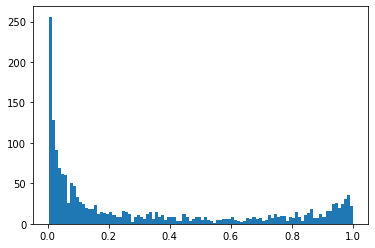

In [62]:
plt.hist(out[out["pred"] > 0]["pred"], bins=100)
None

In [63]:
out[["hgvs_g", "pred"]].to_csv(
    NOTEBOOK_DIR.joinpath("submission-valid-2.tsv"), index=False, sep="\t"
)

In [64]:
# 0.6516511403259807 0.9172607988182891 (without protein features)
# 0.6511556042045329 0.9169435005200913 (with protein features)

In [65]:
# 0.6253383274259249 0.9004123585248509

# 0.21795514450655545 0.8581850558176667
# regression all: 0.22461305628504954 0.8288936050495531

In [66]:
model

In [67]:
clf.importance_type

NameError: name 'clf' is not defined

In [ ]:
clf.feature_importances_

In [ ]:
clf.booster_.feature_importance()

In [ ]:
important_features = clf.booster_.feature_importance() > 0

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt

importantces = np.array(clf.booster_.feature_importance("gain"))
importantces = np.clip(importantces, -1, 100)

plt.hist(importantces, bins=100)
None

In [ ]:
plt.plot(clf.feature_importances_, importantces, "r.")

In [ ]:
import sys

paths = [
    "/gpfs/fs0/scratch/p/pmkim/strokach/workspace/shap-0.39.0",
    "/gpfs/fs0/scratch/p/pmkim/strokach/workspace/shap-hypetune",
    "/gpfs/fs0/scratch/p/pmkim/strokach/workspace/slicer-0.0.7",
]
for p in paths:
    if p not in sys.path:
        sys.path.insert(0, p)

from lightgbm import LGBMClassifier
from scipy import stats
from shaphypetune import BoostBoruta, BoostRFE, BoostSearch

In [ ]:
param_grid = {
    "n_estimators": 150,
    "learning_rate": [0.2, 0.1],
    "num_leaves": [25, 30, 35],
    "max_depth": [10, 12],
}

model = BoostBoruta(
    LGBMClassifier(),
    param_grid=param_grid,
    max_iter=100,
    perc=100,
    importance_type="shap_importances",
    train_importance=False,
)
model.fit(
    X_training,
    y_training,
    eval_set=[(X_testing, y_testing)],
    early_stopping_rounds=6,
    verbose=0,
)

In [ ]:
import lightgbm as lgb
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

score_columns = [
    "el2_score",
    "proteinsolver_core_score_change",
    "protbert_core_score_change",
    #     "rosetta_dg_change",
    "alphafold_core_scores_residue_plddt_wt",
    #     "alphafold_core_scores_protein_plddt_wt",
    #     "alphafold_core_scores_protein_max_predicted_aligned_error_wt",
    #     "alphafold_core_scores_proten_ptm_wt",
]

col = "protbert_core_features_residue_change"

df = result_df.dropna(subset=score_columns + [col, "effect_score"]).sample(frac=1, random_state=0)
df = df[df["effect_score"].isin([-1, 1])].reset_index(drop=True)

amino_acids = list("ARNDCEQGHILKMFPSTWYV")

df["aa_wt_onehot"] = pd.get_dummies(df["mutation"].str[0]).apply(list, axis=1)
df["aa_mut_onehot"] = pd.get_dummies(df["mutation"].str[0]).apply(list, axis=1)

df["preds"] = np.nan
df["pca_preds"] = np.nan

X = np.vstack(df[col].values)

Z = None
Z = np.c_[np.vstack(df["aa_wt_onehot"].values), np.vstack(df["aa_mut_onehot"].values)]
Z = np.c_[
    df[["el2_score", "proteinsolver_core_score_change", "protbert_core_score_change"]].values,
    Z,
]

y = (df["effect_score"] > 0).values.astype(int)


def select_features(X_training, X_testing):
    scaler = StandardScaler()
    scaler.fit(X_training)
    X_training = scaler.transform(X_training)
    X_testing = scaler.transform(X_testing)

    pca = PCA(0.9, svd_solver="full")
    pca.fit(X_training)
    X_training = pca.transform(X_training)
    X_testing = pca.transform(X_testing)
    return X_training, X_testing


params = dict()


n_splits = 6
gkf = GroupKFold(n_splits=n_splits)
for train_index, test_index in tqdm(gkf.split(X, y, groups=df["protein_id"]), total=n_splits):
    X_training, X_testing = X[train_index], X[test_index]
    y_training, y_testing = y[train_index], y[test_index]
    if Z is not None:
        Z_training, Z_testing = Z[train_index], Z[test_index]
        X_training = np.c_[X_training, Z_training]
        X_testing = np.c_[X_testing, Z_testing]

    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_training, y_training, eval_set=[(X_testing, y_testing)], verbose=False)
    df.loc[test_index, "preds"] = clf.predict_proba(X_testing)[:, 1]

    X_training, X_testing = select_features(X[train_index], X[test_index])
    y_training, y_testing = y[train_index], y[test_index]
    if Z is not None:
        Z_training, Z_testing = Z[train_index], Z[test_index]
        X_training = np.c_[X_training, Z_training]
        X_testing = np.c_[X_testing, Z_testing]

    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_training, y_training, eval_set=[(X_testing, y_testing)], verbose=False)
    df.loc[test_index, "pca_preds"] = clf.predict_proba(X_testing)[:, 1]

corr = stats.spearmanr(df["effect_score"], df["preds"])
auc = metrics.roc_auc_score(df["effect_score"] > 0, df["preds"])
print(corr[0], auc)

corr = stats.spearmanr(df["effect_score"], df["pca_preds"])
auc = metrics.roc_auc_score(df["effect_score"] > 0, df["pca_preds"])
print(corr[0], auc)

In [ ]:
# 0.6585175611306802 0.88576012420753
# 0.6547985025461474 0.8835814968157445

In [ ]:
evals = []
for i in tqdm(range(X_training.shape[1])):
    x1 = X_training[:, i]

    corr = stats.spearmanr(df["effect_score"], x1)
    auc = metrics.roc_auc_score(df["effect_score"] > 0, x1)
    evals.append((i, *corr, auc))

evals_df = pd.DataFrame(evals, columns=["i", "corr", "pvalue", "auc"])
evals_df["corr_abs"] = evals_df["corr"].abs()
evals_df = evals_df.sort_values("corr_abs", ascending=False)
del evals_df["corr_abs"]

display(evals_df.head(10))

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0
)

In [ ]:
train_result_df.head()

In [ ]:
import matplotlib.pyplot as plt

plt.hist(x1, bins=100)
plt.hist(x2, bins=100)

None

In [ ]:
x = df["alphafold_core_features_residue_experimentally_resolved_wt"].apply(np.mean)

corr = stats.spearmanr(df["effect_score"], x)
auc = metrics.roc_auc_score(df["effect_score"] > 0, x)

corr, auc

In [ ]:
import lightgbm as lgb

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

col = "alphafold_core_features_residue_msa_first_row_change"

x = np.vstack(df[col].values)
x = StandardScaler().fit_transform(x)
x = PCA(0.9, svd_solver="full").fit_transform(x)

evals = []
for i in tqdm(range(x.shape[1])):
    x1 = x[:, i]

    corr = stats.spearmanr(df["effect_score"], x1)
    auc = metrics.roc_auc_score(df["effect_score"] > 0, x1)
    evals.append((i, *corr, auc))

evals_df = pd.DataFrame(evals, columns=["i", "corr", "pvalue", "auc"])
evals_df["corr_abs"] = evals_df["corr"].abs()
evals_df = evals_df.sort_values("corr_abs", ascending=False)
del evals_df["corr_abs"]

display(evals_df.head(10))

In [ ]:
x.shape

In [ ]:
# col = "alphafold_core_features_residue_experimentally_resolved_wt"  # 0.19 [37]
# col = "alphafold_core_features_residue_experimentally_resolved_change"  # 0.11 [37]
# col = "alphafold_core_features_residue_predicted_lddt_wt"  # 0.17 [50]
# col = "alphafold_core_features_residue_predicted_lddt_change"  # 0.04 [50]
# col = "alphafold_core_features_residue_msa_first_row_wt"  # 0.17 [256]
# col = "alphafold_core_features_residue_msa_first_row_change"  # 0.21 [256]
# col = "alphafold_core_features_residue_single_wt"  # 0.20 [384]
# col = "alphafold_core_features_residue_single_change"  # 0.15 [384]
# col = "alphafold_core_features_residue_structure_module_wt"  # 0.18 [384]
col = "alphafold_core_features_residue_structure_module_change"  # 0.05 [384]

col = "protbert_core_features_residue_change"  # 0.13 [1024]

# col = "alphafold_core_features_protein_experimentally_resolved_wt"  #
# col = "alphafold_core_features_protein_predicted_lddt_wt"  #
# col = "alphafold_core_features_protein_msa_first_row_wt"  #
# col = "alphafold_core_features_protein_single_wt"  #
# col = "alphafold_core_features_protein_structure_module_wt"  #

num_features = len(result_df[col][0])

evals = []
for i in tqdm(range(num_features)):
    x1 = df[col].str[i]

    corr = stats.spearmanr(df["effect_score"], x1)
    auc = metrics.roc_auc_score(df["effect_score"] > 0, x1)
    evals.append((i, *corr, auc))

evals_df = pd.DataFrame(evals, columns=["i", "corr", "pvalue", "auc"])
evals_df["corr_abs"] = evals_df["corr"].abs()
evals_df = evals_df.sort_values("corr_abs", ascending=False)
del evals_df["corr_abs"]

display(evals_df.head(10))

In [ ]:
scores_proten_ptm

In [ ]:
validation_df.head()

In [ ]:
validation_submission_df = validation_df.assign(is_missense=lambda df: df["hgvs"].notnull()).merge(
    result_df, left_on=["hgvs"], right_on=["mutation_id"], how="left"
)

assert len(validation_submission_df) == len(validation_df)

In [ ]:
out = (
    validation_submission_df.groupby("hgvs_g")
    .agg({"el2_score": np.nanmean, "is_missense": "max"})
    .fillna(0.0)
    .reset_index()
)

out.head()

In [ ]:
out[["hgvs_g", "el2_score"]].to_csv(
    NOTEBOOK_DIR.joinpath("submission-valid.tsv"), index=False, sep="\t"
)

In [ ]:
validation_submission_df.head()

In [ ]:
df.columns